## Setup

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, TensorDataset

from src.data import DataLoaderScratch
from src.trainer import TrainerScratch
from src.optimizers import SGDScratch

## Load Data

In [2]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

## Preprocessing

In [3]:
# Transform the training data
X_train = mnist_trainset.data.float() / 255.0
X_train = X_train.view(X_train.shape[0], -1)
y_train = mnist_trainset.targets

# Transform the test data
X_val = mnist_testset.data.float() / 255.0
X_val = X_val.view(X_val.shape[0], -1)
y_val = mnist_testset.targets

train_dataloader = DataLoaderScratch(X_train, y_train, batch_size=256, shuffle=True)
val_dataloader = DataLoaderScratch(X_val, y_val, batch_size=256, shuffle=False)

## Logistic Regression From Scratch

### Single Batch from Scratch

In [4]:
num_samples = X_train.shape[0]
num_classes = y_train.unique().shape[0]
batch_size = 64

# Initialize W, it should be shape (num_features, num_classes) because it will 
# transform the input (num_examples, num_features) to the output (num_examples, num_classes)
W = torch.randn(size=(X_train.shape[1], num_classes), requires_grad=True)
# Initialize b, it should be shape (1, 1) because it will be a scalar we add to each class 
# prediction for each example
b = torch.zeros(num_classes, requires_grad=True)
                
# Define softmax, which maps scalars to probabilities
def softmax(X):
    X_exp = torch.exp(X)
    return X_exp / X_exp.sum(axis=1, keepdims=True)

# Define the log-loss 
def log_loss(y_pred, y):
    y_one_hot = nn.functional.one_hot(y)
    loss = -(y_one_hot * torch.log(y_pred)).sum(axis=1).mean()
    return loss

parameters = [W, b]
optimizer = SGDScratch(parameters, lr=0.1)

# Create a batch
X_batch = X_train[: batch_size]
y_batch = y_train[: batch_size]

In [5]:
# Zero gradients
optimizer.zero_grad()

# Forward pass (training)
O = X_batch @ W + b
y_pred = softmax(O)

# Calculate Loss
loss = log_loss(y_pred, y_batch)

# Backward pass (compute gradients)
loss.backward()

# Update parameters
optimizer.step()

### Define Training Loop and Model

In [6]:
def accuracy(y_pred, y_true):
    label_pred = torch.argmax(y_pred, axis=1)
    accuracy = torch.sum(label_pred == y_true) / y_pred.shape[0]
    return accuracy

In [7]:
class LogisticRegressionScratch(nn.Module):
    def __init__(self, in_features, num_classes):
        super().__init__()
        self.num_classes = num_classes
        self.W = torch.randn(size=(in_features, num_classes), requires_grad=True)
        self.b = torch.zeros(num_classes, requires_grad=True)

    def softmax(self, X):
        X_exp = torch.exp(X)
        X_softmax = X_exp / X_exp.sum(axis=1, keepdims=True)
        return X_softmax

    def forward(self, X):
        O = X @ self.W + self.b
        y_pred = self.softmax(O)
        return y_pred
    
    def parameters(self):
        return [self.W, self.b]

In [8]:
class CrossEntropyScratch(nn.Module):
    def __init__(self, num_classes):
        super(CrossEntropyScratch, self).__init__()
        self.num_classes = num_classes

    def forward(self, y_pred, y_true):
        y_one_hot = nn.functional.one_hot(y_true, self.num_classes)
        loss = -(y_one_hot * torch.log(y_pred)).sum(axis=1).mean()
        return loss

### Training the Model

In [9]:
class AccuracyScratch:
    def __init__(self):
        self.correct = 0
        self.total = 0

    def update(self, outputs, targets):
        _, predicted = torch.max(outputs, 1)
        self.correct += (predicted == targets).sum().item()
        self.total += targets.size(0)

    def compute(self):
        return self.correct / self.total if self.total else 0

    def reset(self):
        self.correct = 0
        self.total = 0

Epoch 1/15, Training Loss: 7.9799, Validation Loss: 6.3513
Validation accuracy: 0.2531
Epoch 2/15, Training Loss: 5.5977, Validation Loss: 4.8640
Validation accuracy: 0.3344
Epoch 3/15, Training Loss: 4.4558, Validation Loss: 3.9667
Validation accuracy: 0.4085
Epoch 4/15, Training Loss: 3.7341, Validation Loss: 3.3794
Validation accuracy: 0.4655
Epoch 5/15, Training Loss: 3.2359, Validation Loss: 2.9670
Validation accuracy: 0.5105
Epoch 6/15, Training Loss: 2.8805, Validation Loss: 2.6620
Validation accuracy: 0.5471
Epoch 7/15, Training Loss: 2.6093, Validation Loss: 2.4276
Validation accuracy: 0.5736
Epoch 8/15, Training Loss: 2.4005, Validation Loss: 2.2408
Validation accuracy: 0.5986
Epoch 9/15, Training Loss: 2.2302, Validation Loss: 2.0891
Validation accuracy: 0.6192
Epoch 10/15, Training Loss: 2.0905, Validation Loss: 1.9630
Validation accuracy: 0.6348
Epoch 11/15, Training Loss: 1.9716, Validation Loss: 1.8568
Validation accuracy: 0.6505
Epoch 12/15, Training Loss: 1.8727, Valid

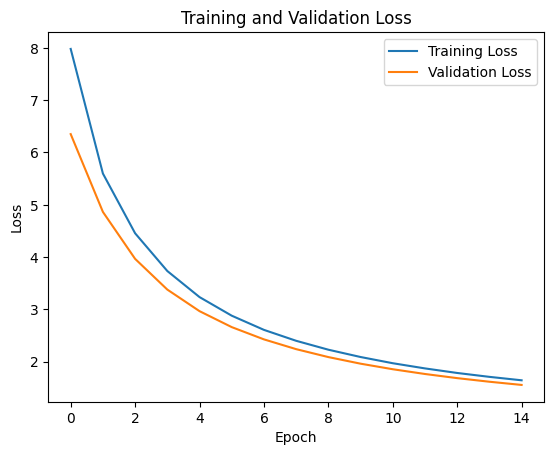

In [10]:
in_features = X_train.shape[1]
num_classes = y_train.unique().shape[0]
num_epochs = 15
learning_rate = 0.01

model = LogisticRegressionScratch(in_features=in_features, num_classes=num_classes)
optimizer = SGDScratch(model.parameters(), lr=learning_rate)
criterion = CrossEntropyScratch(num_classes=num_classes)
metrics = {'accuracy':AccuracyScratch()}
trainer = TrainerScratch(model, train_dataloader, val_dataloader, optimizer, criterion, custom_metrics=metrics)
trainer.fit(num_epochs=num_epochs)

## Concise Implementation of Logistic Regression

Epoch 1/10, Training Loss: 2.0318, Validation Loss: 1.8298
Epoch 2/10, Training Loss: 1.7840, Validation Loss: 1.7395
Epoch 3/10, Training Loss: 1.7315, Validation Loss: 1.7081
Epoch 4/10, Training Loss: 1.7083, Validation Loss: 1.6917
Epoch 5/10, Training Loss: 1.6947, Validation Loss: 1.6811
Epoch 6/10, Training Loss: 1.6853, Validation Loss: 1.6734
Epoch 7/10, Training Loss: 1.6782, Validation Loss: 1.6675
Epoch 8/10, Training Loss: 1.6718, Validation Loss: 1.6598
Epoch 9/10, Training Loss: 1.6565, Validation Loss: 1.6374
Epoch 10/10, Training Loss: 1.6398, Validation Loss: 1.6241


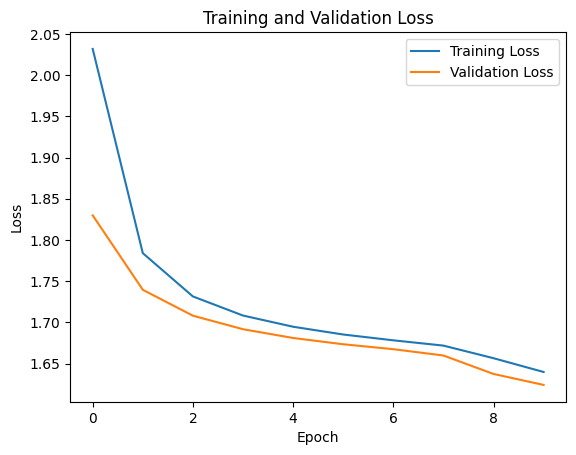

In [11]:
# Assuming X and y are your feature and target tensors
# Split Data into Train and Test Sets
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)

# Define DataLoader
batch_size = 256
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size)

# Define the Linear Regression Model
class LogisticRegression(nn.Module):
    def __init__(self, input_size, num_classes):
        super(LogisticRegression, self).__init__()
        self.linear = nn.Linear(input_size, num_classes)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        out = self.linear(x)
        out = self.softmax(out)
        return out

model = LogisticRegression(input_size=X_train.shape[1], num_classes=y_train.unique().shape[0])

# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1)
trainer = TrainerScratch(model, train_dataloader, val_dataloader, optimizer, criterion)
trainer.fit(num_epochs=10)